## EXERCISE 0

Download and extract the Python version of the CIFAR dataset from the CIFAR website.  
The dataset is structured as follows:

- **5 training batches** of 10,000 images each (50,000 images total)  
- **1 test batch** of 10,000 images  

Each batch file contains a **dictionary** with the following elements:

- **`data`** – a 10,000 × 3,072 NumPy array of `uint8`.  
  Each row represents a 32×32 color image:  
  - The first 1,024 entries are the red channel,  
  - The next 1,024 entries are the green channel,  
  - The final 1,024 entries are the blue channel.  
  Images are stored in **row-major order**, i.e., the first 32 entries correspond to the red values of the first row of the image.

- **`labels`** – a list of 10,000 integers in the range 0–9.  
  The number at index `i` indicates the label of the `i`th image in `data`.

The dataset also contains another file called **`batches.meta`**, which is a Python dictionary with the following entry:

- **`label_names`** – a 10-element list giving meaningful names to the numeric labels in the `labels` array described above.  
  For example:  
  ```python
  label_names[0] == "airplane"
  label_names[1] == "automobile"
  # etc.


Number of training samples: 50000
Image shape: torch.Size([3, 32, 32]) Label: 6


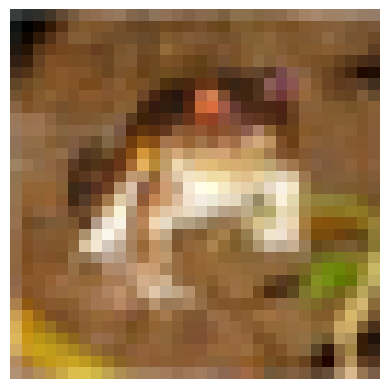

Label: 6


In [1]:
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class CIFAR10Dataset(Dataset):
    def __init__(self, path, data_type='train', transform=None):
        """
        Args:
            path (str): path to the CIFAR-10 data files
            data_type (str): 'train' or 'test'
            transform (callable, optional): transformation to apply to each image
        """
        self.path = path
        self.transform = transform
        self.data = []
        self.labels = []

        if data_type == 'train':
            # load all 5 training batches
            for i in range(1, 6):
                file = f"{path}/data_batch_{i}"
                with open(file, 'rb') as fo:
                    batch = pickle.load(fo, encoding='bytes')
                    # reshape to (10000,3,32,32)
                    imgs = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                    self.data.append(imgs)
                    self.labels += batch[b'labels']
            self.data = np.vstack(self.data)  # shape (50000,3,32,32)
        elif data_type == 'test':
            file = f"{path}/test_batch"
            with open(file, 'rb') as fo:
                batch = pickle.load(fo, encoding='bytes')
                self.data = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                self.labels = batch[b'labels']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  # CHW
        label = self.labels[idx]

        # Convert CHW -> HWC for ToTensor
        img = np.transpose(img, (1, 2, 0))

        # Apply transformation if provided
        if self.transform:
            img = self.transform(img)

        return img, label

    def visualize(self, img):
        """Visualize a single image (tensor or NumPy array)."""
        if isinstance(img, torch.Tensor):
            img = img.clone().detach()
            img = img.numpy()
            img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
            img = img * 0.5 + 0.5  # denormalize
        elif img.max() > 1.0:
            img = img / 255.0  # normalize if uint8

        plt.imshow(img)
        plt.axis('off')
        plt.show()


# ------------------------------
# Main: Instantiate and test
# ------------------------------

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # converts HWC uint8 image to CHW float tensor [0,1]
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # normalize to [-1,1]
])

# Load the dataset
dataset = CIFAR10Dataset(path='data', data_type='train', transform=transform)

# Check dataset size
print("Number of training samples:", len(dataset))

# Get one sample
img, label = dataset[0]
print("Image shape:", img.shape, "Label:", label)

# Visualize first 5 images
for i in range(1):
    img, label = dataset[i]
    dataset.visualize(img)
    print("Label:", label)


## **EXERCISE 2** 
Build a CNN model to predict a class from the input image (you can use
the Conv2D module and one of the plenty pooling layers already implemented).

Which are the main hyperparameters you should set to build the main model?

Good practice is to build the model class as general as possible, and specify the
hyperparaemeters when the class is called.

#### **Explanation**

In the follwing code there is implemented a general convolutional neural network (CNN) that mimics the standard CNN pipeline studied in class:

Convolution → Activation → Pooling → Flatten → Fully connected → Output.


#### **Exercise E2 – Building a General CNN Explanation**

This model defines a <strong>flexible CNN architecture</strong> that can later be configured with
specific hyperparameters (for Exercise E3). It follows exactly the theory from the Convolutional Neural Network lecture.</p>

#### **Main components:**

- <strong>Convolution layers</strong>: learn feature detectors that extract edges, textures, and shapes.
- <strong>Activation (ReLU)</strong>: introduces non-linearity, letting the model learn complex features.
- <strong>Pooling</strong>: reduces spatial size, making the network more robust to position changes.
- <strong>Flattening</strong>: converts 3D feature maps into a 1D vector.
- <strong>Fully Connected layers</strong>: perform the classification using learned features.


#### **Main hyperparameters to specify:**

- Number of convolutional layers and filters
- Kernel size of each convolution
- Pooling type (max or average), kernel, and stride
- Number of neurons in fully connected layers
- Number of output classes

#### **Good practice:**
The model class is <strong>general</strong>: all hyperparameters can be set when the class is called,
and the fully connected layers are created automatically based on the input size. This ensures reusability and avoids hardcoding.</p>




### **Which main hyperparameters must we set?**

1. **Convolutional hyperparameters:**

- conv1_channels, conv2_channels — number of filters in each conv layer (controls model capacity / feature depth). Lecture: depth equals number of filters. 

- kernel_size — the size of each filter (e.g., 5 means 5×5). Larger kernel → bigger receptive field (detects larger patterns). 

- padding and stride — used to control output size and sampling.

2. **Pooling hyperparameters**

- pool_type — 'avg' or 'max' (lecture explains both). Max is common for feature preservation; average sometimes used where smoothing is desirable. 

- pool_kernel & pool_stride — window size and stride for downsampling (lecture: pooling has these hyperparameters). 

3. **Fully connected hyperparameters**

- fc_spatial (Approach A) or fc1_units, fc2_units — number of neurons in FC layers (controls classifier capacity). The lecture mentions designing FC layers after flattening. 

4. **Other general choices**

- num_classes — target number of classes (here CIFAR-10 → 10).

- Activation choice — ReLU is standard and recommended in lecture. 

These are all exposed as __init__ arguments in the model classes above, so I can instantiate many variants without changing the class body.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class GeneralCNN(nn.Module):
    
    def __init__(self, 
                 in_channels=3, 
                 num_classes=10, 
                 conv_layers=[(6, 5), (16, 5)], 
                 pool_type='max',
                 pool_kernel=3,
                 pool_stride=2,
                 fc_layers=[120, 84],
                 activation='relu'): 
        """
        A general CNN model structure for image classification tasks.
        """

        super(GeneralCNN, self).__init__()

        # Salviamo la funzione di attivazione come attributo
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        else:
            raise ValueError("Unsupported activation function")
        
        self.layers = nn.ModuleList()
        current_channels = in_channels

        # Costruzione dei layer convoluzionali
        for out_channels, kernel_size in conv_layers:
            conv = nn.Conv2d(current_channels, out_channels, kernel_size=kernel_size)
            self.layers.append(conv)
            current_channels = out_channels

        # Pooling
        if pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)
        else:
            raise ValueError("pool_type must be 'max' or 'avg'")

        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        self.fc_config = fc_layers
        self.num_classes = num_classes


        # L’inizializzazione dei fully connected layer verrà fatta nel forward
        # dopo aver conosciuto la dimensione flatten


    ## This defines the fully connected layers, because their input size depends on the output size of the convolution+pooling part.
    def build_fc_layers(self, flattened_size): #method that creates the layers dynamically the first time the model runs
        """Define fully connected layers once flattened size is known."""
        layers = []
        input_size = flattened_size
        for units in self.fc_config:
            layers.append(nn.Linear(input_size, units))
            input_size = units
        layers.append(nn.Linear(input_size, self.num_classes))
        self.fc_layers = nn.ModuleList(layers)
        #print(f"Building FC layers with input size {flattened_size}")



    ## Called every time you call the model with data (model(x)):
    # Applies the operations defined in __init__ (and those added in build_fc_layers) to the input data — in the correct sequence.
    def forward(self, x):
        # Apply convolutional layers with optional pooling per layer
        for i, conv in enumerate(self.layers):
            x = conv(x)
            x = self.activation(x)
            if isinstance(self.pool, list):  # multiple pools (optional)
                if i < len(self.pool) and self.pool[i] is not None:
                    x = self.pool[i](x)
            elif self.pool is not None:  # single shared pool (old behavior)
                x = self.pool(x)
        # Flatten
        x = torch.flatten(x, 1)

        # Build FC layers dynamically (first pass)
        if not self.fc_layers:
            self.build_fc_layers(x.shape[1])

        # Fully connected layers
        for i, fc in enumerate(self.fc_layers):
            if i < len(self.fc_layers) - 1:
                x = self.activation(fc(x))
            else:
                x = fc(x)
        return x



REAL DATA MAIN

conda install -c conda-forge ipywidgets; 
conda install tqdm


In [10]:
# 1. Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

# Assuming CIFAR10Dataset and GeneralCNN are already defined above

# 2. Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# 3. Dataset
train_dataset = CIFAR10Dataset(path='data', data_type='train', transform=transform)
test_dataset = CIFAR10Dataset(path='data', data_type='test', transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Model
model = GeneralCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 5. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 6. Training loop with progress bars + loss tracking
num_epochs = 50
train_losses = [] 

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    running_loss = 0.0
    
    batch_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Batches", leave=False)
    for i, (images, labels) in enumerate(batch_loop):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # Update batch progress bar with current average loss
        batch_loop.set_postfix({"loss": running_loss / (i+1)})
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {epoch_loss:.4f}")

print("Training finished!")


Epoch [1/50] - Avg Loss: 2.3023
Epoch [2/50] - Avg Loss: 2.2999
Epoch [3/50] - Avg Loss: 2.2976
Epoch [4/50] - Avg Loss: 2.2948
Epoch [5/50] - Avg Loss: 2.2918
Epoch [6/50] - Avg Loss: 2.2886
Epoch [7/50] - Avg Loss: 2.2853
Epoch [8/50] - Avg Loss: 2.2820
Epoch [9/50] - Avg Loss: 2.2787
Epoch [10/50] - Avg Loss: 2.2756
Epoch [11/50] - Avg Loss: 2.2726
Epoch [12/50] - Avg Loss: 2.2696
Epoch [13/50] - Avg Loss: 2.2665
Epoch [14/50] - Avg Loss: 2.2632
Epoch [15/50] - Avg Loss: 2.2592
Epoch [16/50] - Avg Loss: 2.2547
Epoch [17/50] - Avg Loss: 2.2496
Epoch [18/50] - Avg Loss: 2.2445
Epoch [19/50] - Avg Loss: 2.2394
Epoch [20/50] - Avg Loss: 2.2347
Epoch [21/50] - Avg Loss: 2.2303
Epoch [22/50] - Avg Loss: 2.2259
Epoch [23/50] - Avg Loss: 2.2216
Epoch [24/50] - Avg Loss: 2.2176
Epoch [25/50] - Avg Loss: 2.2137
Epoch [26/50] - Avg Loss: 2.2099
Epoch [27/50] - Avg Loss: 2.2063
Epoch [28/50] - Avg Loss: 2.2027
Epoch [29/50] - Avg Loss: 2.1993
Epoch [30/50] - Avg Loss: 2.1959
Epoch [31/50] - Avg

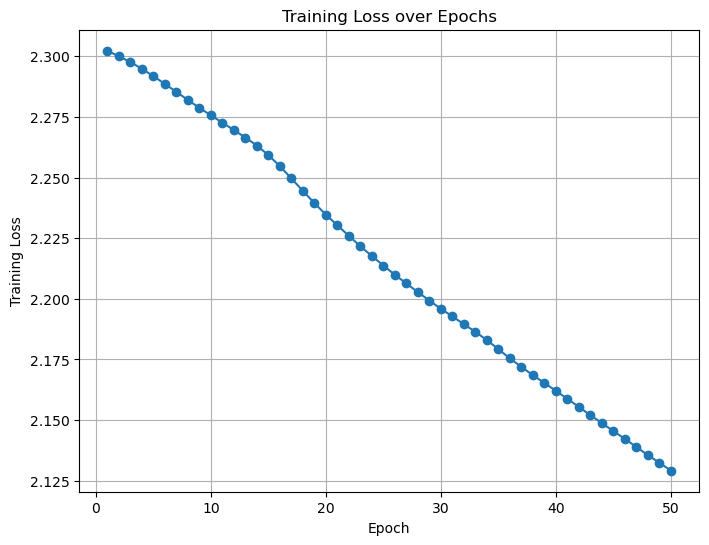

In [11]:
# -----------------------------
# Plot training loss over epochs
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

Overall Test Accuracy: 0.2179
              precision    recall  f1-score   support

           0     0.2587    0.7030    0.3783      1000
           1     0.2126    0.0370    0.0630      1000
           2     0.6000    0.0030    0.0060      1000
           3     0.1818    0.2200    0.1991      1000
           4     0.0000    0.0000    0.0000      1000
           5     0.1797    0.6270    0.2793      1000
           6     0.2343    0.3200    0.2705      1000
           7     0.1680    0.0650    0.0937      1000
           8     0.2910    0.0710    0.1141      1000
           9     0.3260    0.1330    0.1889      1000

    accuracy                         0.2179     10000
   macro avg     0.2452    0.2179    0.1593     10000
weighted avg     0.2452    0.2179    0.1593     10000

Mean ROC AUC: 0.7182


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


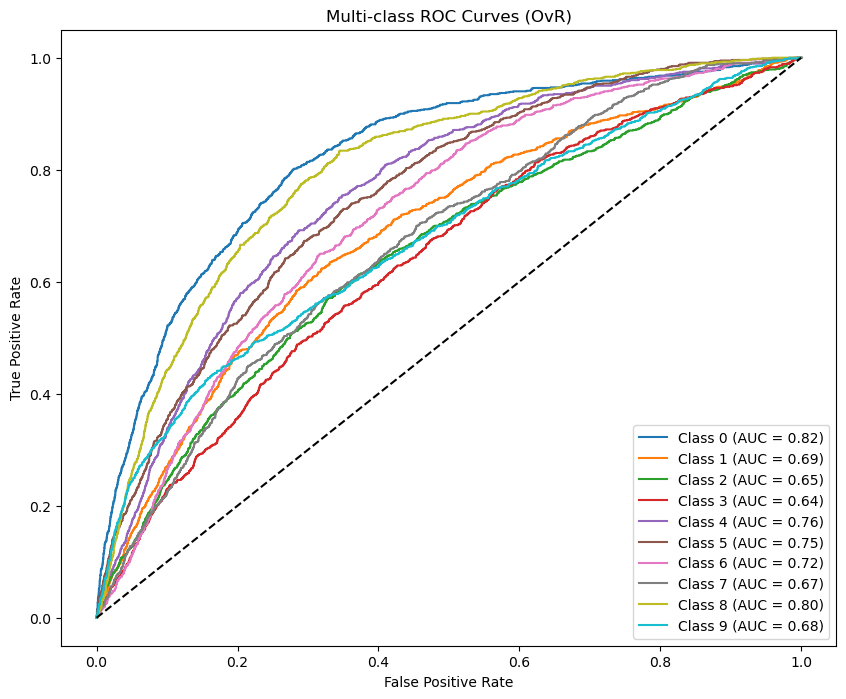

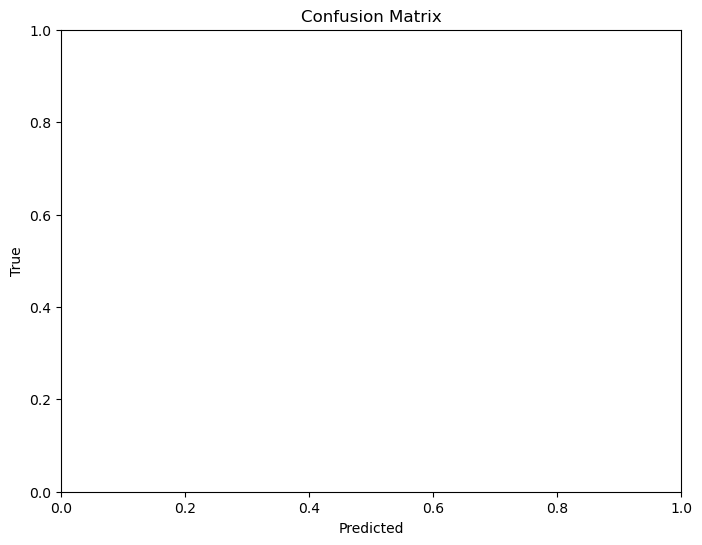

In [12]:
# -----------------------------
# Evaluation
# -----------------------------

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize
#import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_preds.append(probs.cpu())
        all_labels.append(labels)

all_preds = torch.cat(all_preds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Accuracy
pred_classes = all_preds.argmax(axis=1)
accuracy = accuracy_score(all_labels, pred_classes)
print(f"Overall Test Accuracy: {accuracy:.4f}")

# Per-class precision, recall, f1
print(classification_report(all_labels, pred_classes, digits=4))

# Mean ROC AUC (one-vs-rest)
n_classes = 10
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))
roc_auc = roc_auc_score(all_labels_bin, all_preds, multi_class='ovr')
print(f"Mean ROC AUC: {roc_auc:.4f}")


# Optional: plot ROC curves for each class
plt.figure(figsize=(10,8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_preds[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr,tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves (OvR)')
plt.legend(loc='lower right')
plt.show()

# Optional: Confusion matrix
cm = confusion_matrix(all_labels, pred_classes)
plt.figure(figsize=(8,6))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")


Total trainable parameters: 62006


Code that adds padding, corrected the kernel size to 3 instead of 2, num_epochs = 50 and batch size 64, still accuracy pretty low :(

Epoch [1/50] - Avg Loss: 2.3031
Epoch [2/50] - Avg Loss: 2.3014
Epoch [3/50] - Avg Loss: 2.2988
Epoch [4/50] - Avg Loss: 2.2947
Epoch [5/50] - Avg Loss: 2.2893
Epoch [6/50] - Avg Loss: 2.2835
Epoch [7/50] - Avg Loss: 2.2773
Epoch [8/50] - Avg Loss: 2.2707
Epoch [9/50] - Avg Loss: 2.2639
Epoch [10/50] - Avg Loss: 2.2574
Epoch [11/50] - Avg Loss: 2.2507
Epoch [12/50] - Avg Loss: 2.2437
Epoch [13/50] - Avg Loss: 2.2368
Epoch [14/50] - Avg Loss: 2.2299
Epoch [15/50] - Avg Loss: 2.2237
Epoch [16/50] - Avg Loss: 2.2176
Epoch [17/50] - Avg Loss: 2.2134
Epoch [18/50] - Avg Loss: 2.2080
Epoch [19/50] - Avg Loss: 2.2038
Epoch [20/50] - Avg Loss: 2.1999
Epoch [21/50] - Avg Loss: 2.1947
Epoch [22/50] - Avg Loss: 2.1905
Epoch [23/50] - Avg Loss: 2.1877
Epoch [24/50] - Avg Loss: 2.1835
Epoch [25/50] - Avg Loss: 2.1797
Epoch [26/50] - Avg Loss: 2.1743
Epoch [27/50] - Avg Loss: 2.1712
Epoch [28/50] - Avg Loss: 2.1686
Epoch [29/50] - Avg Loss: 2.1631
Epoch [30/50] - Avg Loss: 2.1594
Epoch [31/50] - Avg

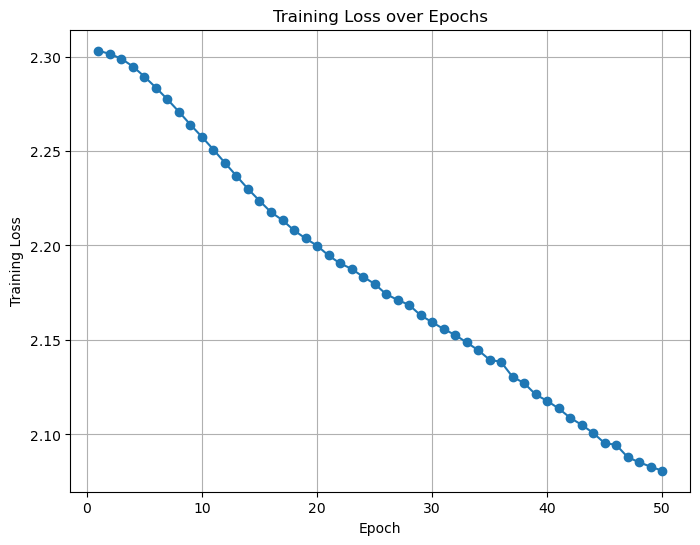

Overall Test Accuracy: 0.2366
              precision    recall  f1-score   support

           0     0.5031    0.0820    0.1410      1000
           1     0.1705    0.8450    0.2837      1000
           2     0.2907    0.1840    0.2254      1000
           3     0.2550    0.0890    0.1319      1000
           4     0.3193    0.1060    0.1592      1000
           5     0.2629    0.3160    0.2870      1000
           6     0.3467    0.3620    0.3542      1000
           7     0.2774    0.3270    0.3001      1000
           8     0.6250    0.0050    0.0099      1000
           9     0.3759    0.0500    0.0883      1000

    accuracy                         0.2366     10000
   macro avg     0.3426    0.2366    0.1981     10000
weighted avg     0.3426    0.2366    0.1981     10000

Mean ROC AUC: 0.7470


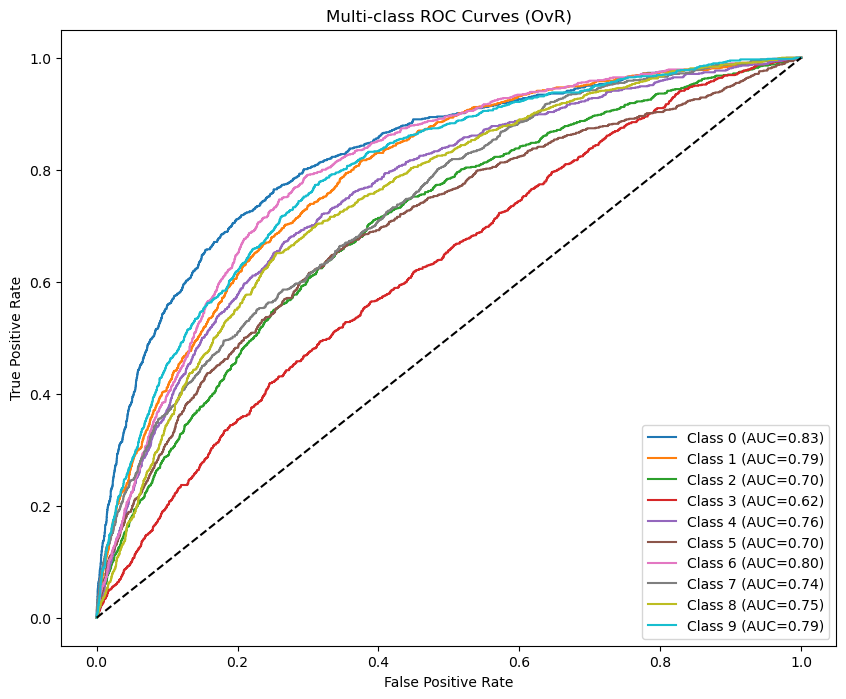

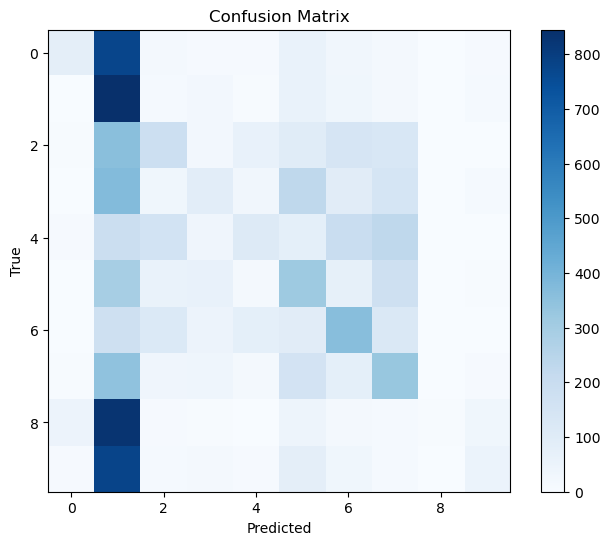

In [17]:
# -----------------------------
# 1. Imports
# -----------------------------
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize

# -----------------------------
# 2. Dataset Class
# -----------------------------
class CIFAR10Dataset(Dataset):
    def __init__(self, path, data_type='train', transform=None):
        self.path = path
        self.transform = transform
        self.data = []
        self.labels = []

        if data_type == 'train':
            for i in range(1, 6):
                file = f"{path}/data_batch_{i}"
                with open(file, 'rb') as fo:
                    batch = pickle.load(fo, encoding='bytes')
                    imgs = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                    self.data.append(imgs)
                    self.labels += batch[b'labels']
            self.data = np.vstack(self.data)
        elif data_type == 'test':
            file = f"{path}/test_batch"
            with open(file, 'rb') as fo:
                batch = pickle.load(fo, encoding='bytes')
                self.data = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                self.labels = batch[b'labels']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  # CHW
        label = self.labels[idx]

        img = np.transpose(img, (1, 2, 0))  # HWC
        img = Image.fromarray(img)  # Convert to PIL Image for torchvision transforms

        if self.transform:
            img = self.transform(img)
        return img, label

    def visualize(self, img):
        if isinstance(img, torch.Tensor):
            img = img.clone().detach()
            img = img.numpy()
            img = np.transpose(img, (1, 2, 0))
            img = img * 0.5 + 0.5  # denormalize
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# -----------------------------
# 3. CNN Model
# -----------------------------
class GeneralCNN(nn.Module):
    def __init__(self, 
                 in_channels=3, 
                 num_classes=10, 
                 conv_layers=[(6, 5), (16, 5)], 
                 pool_type='max',
                 pool_kernel=3,
                 pool_stride=2,
                 fc_layers=[120, 84],
                 activation='relu'): 
        super(GeneralCNN, self).__init__()

        # Activation
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        else:
            raise ValueError("Unsupported activation function")

        self.layers = nn.ModuleList()
        current_channels = in_channels

        # Convolutional layers with padding=2 to preserve spatial size
        for out_channels, kernel_size in conv_layers:
            conv = nn.Conv2d(current_channels, out_channels, kernel_size=kernel_size, padding=2)
            self.layers.append(conv)
            current_channels = out_channels

        # Pooling
        if pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)
        else:
            raise ValueError("pool_type must be 'max' or 'avg'")

        # Fully connected layers (initialized later)
        self.fc_layers = nn.ModuleList()
        self.fc_config = fc_layers
        self.num_classes = num_classes

    def build_fc_layers(self, flattened_size):
        layers = []
        input_size = flattened_size
        for units in self.fc_config:
            layers.append(nn.Linear(input_size, units))
            input_size = units
        layers.append(nn.Linear(input_size, self.num_classes))
        self.fc_layers = nn.ModuleList(layers)

    def forward(self, x):
        for i, conv in enumerate(self.layers):
            x = conv(x)
            x = self.activation(x)
            x = self.pool(x)
        x = torch.flatten(x, 1)

        if not self.fc_layers:
            self.build_fc_layers(x.shape[1])

        for i, fc in enumerate(self.fc_layers):
            if i < len(self.fc_layers) - 1:
                x = self.activation(fc(x))
            else:
                x = fc(x)
        return x

# -----------------------------
# 4. Data and Transformations
# -----------------------------
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = CIFAR10Dataset(path='data', data_type='train', transform=transform_train)
test_dataset = CIFAR10Dataset(path='data', data_type='test', transform=transform_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -----------------------------
# 5. Model, Loss, Optimizer
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GeneralCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# -----------------------------
# 6. Training
# -----------------------------
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {epoch_loss:.4f}")

# Plot training loss
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

# -----------------------------
# 7. Evaluation
# -----------------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_preds.append(probs.cpu())
        all_labels.append(labels)

all_preds = torch.cat(all_preds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Accuracy
pred_classes = all_preds.argmax(axis=1)
accuracy = accuracy_score(all_labels, pred_classes)
print(f"Overall Test Accuracy: {accuracy:.4f}")

# Classification report
print(classification_report(all_labels, pred_classes, digits=4))

# Mean ROC AUC
n_classes = 10
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))
roc_auc = roc_auc_score(all_labels_bin, all_preds, multi_class='ovr')
print(f"Mean ROC AUC: {roc_auc:.4f}")

# ROC Curves
plt.figure(figsize=(10,8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_preds[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc(fpr,tpr):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves (OvR)')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix
cm = confusion_matrix(all_labels, pred_classes)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## **First Full Version - 13/11/2025 ----------------------------------------------------------**
**Full code with changes. Main changes done with git copilot and why:**

- GeneralCNN.init: build FC layers there (marked "# --- CHANGED ---"). This prevents the optimizer from being created before FC params exist. This is the core fix for the original critical bug.

- CIFAR10Dataset labels -> numpy int64 and return int in getitem (two "# --- CHANGED ---" marks). This avoids dtype/collation surprises.

- DataLoader: set num_workers = 0 and pin_memory only for CUDA (marked "# --- CHANGED ---"). Your traceback shows multiprocessing spawn pickling error (Can't get attribute 'CIFAR10Dataset' on <module 'main'>). That error commonly happens when DataLoader uses subprocesses in an environment where the dataset class cannot be imported by worker processes (interactive environments or macOS spawn). Setting num_workers=0 avoids multiprocessing and the error. If you run this script as a standalone python file and want multi-worker loading, you can increase num_workers and ensure the file is run as a script (not inside interactive notebook) and classes are importable.

In [ ]:
"""
Corrected CIFAR-10 training script.

Key fixes (each change is marked with "# --- CHANGED ---" where applied):
 - Build fully-connected layers inside GeneralCNN.__init__ so all parameters exist before creating the optimizer.
 - Convert dataset labels to numpy int64 and ensure __getitem__ returns a Python int.
 - Create optimizer after model parameters are created (no missing FC params).
 - Avoid multiprocessing pickling error by using num_workers=0 on DataLoader when spawn/MPS is used.
 - Make pin_memory conditional on CUDA so you don't get MPS pin_memory warnings.
 - Add a debug assert to check optimizer param count matches model param count.

Run: python train_cifar_fixed.py
"""
import os 
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# ----------------------------
# Dataset
# ----------------------------
class CIFAR10Dataset(Dataset):
    def __init__(self, path, data_type='train', transform=None):
        """
        Args:
            path (str): path to the CIFAR-10 data files (data_batch_1..5 and test_batch)
            data_type (str): 'train' or 'test'
            transform (callable, optional): transformation to apply to each image
        """
        self.path = path
        self.transform = transform

        if data_type == 'train':
            data_list = []  # --- CHANGED --- Now inside the if block
            labels_list = []  # --- CHANGED --- Now inside the if block
            for i in range(1, 6):
                file = os.path.join(path, f"data_batch_{i}")
                with open(file, 'rb') as fo:
                    batch = pickle.load(fo, encoding='bytes')
                    # reshape to (10000,3,32,32)
                    imgs = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                    data_list.append(imgs)
                    labels_list.extend(batch[b'labels'])
            self.data = np.vstack(data_list)  # shape (50000,3,32,32)
            self.labels = np.array(labels_list, dtype=np.int64)  # --- CHANGED ---
        elif data_type == 'test':
            file = os.path.join(path, "test_batch")
            with open(file, 'rb') as fo:
                batch = pickle.load(fo, encoding='bytes')
                self.data = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                self.labels = np.array(batch[b'labels'], dtype=np.int64)  # --- CHANGED ---
        else:
            raise ValueError("data_type must be 'train' or 'test'")  # --- CHANGED ---

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # self.data is CHW uint8 array
        img = self.data[idx]  # CHW (3,32,32)
        label = int(self.labels[idx])  # --- CHANGED --- ensure Python int / torch will collate to LongTensor 

        # Convert CHW -> HWC for transforms.ToTensor which expects HWC numpy or PIL
        img = np.transpose(img, (1, 2, 0)).astype(np.uint8)  # HWC --- CHANGED ---

        if self.transform:
            img = self.transform(img)

        return img, label

    def visualize(self, img):
        """Visualize a single image (tensor or NumPy array)."""
        if isinstance(img, torch.Tensor):
            t = img.clone().cpu()
            t = t * 0.5 + 0.5  # unnormalize for the default Normalize((0.5,...),(0.5,...))
            npimg = t.numpy()
            npimg = np.transpose(npimg, (1, 2, 0))
            plt.imshow(npimg)
        else:
            plt.imshow(img)
        plt.axis('off')
        plt.show()


Number of training samples: 50000
Label: 6 (frog)


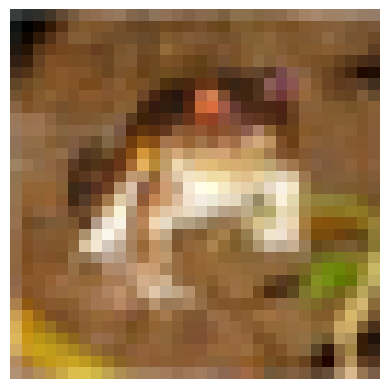

In [17]:
# ----------------------------
# Main: Instantiate & Visualize
# ----------------------------
if __name__ == "__main__":
    # Class names
    cifar10_classes = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),  # converts HWC -> CHW and scales [0,255] to [0,1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1,1]
    ])

    # Load dataset
    dataset = CIFAR10Dataset(path='data', data_type='train', transform=transform)

    print("Number of training samples:", len(dataset))

    # Visualize first image
    for i in range(1):
        img, label = dataset[i]
        print(f"Label: {label} ({cifar10_classes[label]})")
        dataset.visualize(img)


In [18]:
# ----------------------------
# Model
# ----------------------------
class GeneralCNN(nn.Module):
    def __init__(self,
                 in_channels=3,
                 num_classes=10,
                 conv_layers=[(6, 5), (16, 5)],
                 pool_type='max',
                 pool_kernel=3,
                 pool_stride=2,
                 fc_layers=[120, 84],
                 activation='relu',
                 input_size=(32, 32)):
        """
        General CNN. Fully-connected layers are built inside __init__ (using
        a dummy tensor) so parameters exist before optimizer creation.
        This fixes the critical bug where FCs were created in forward().
        """
        super(GeneralCNN, self).__init__()

        # Activation selection
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        else:
            raise ValueError("Unsupported activation")

        self.layers = nn.ModuleList()
        current_channels = in_channels

        # Convolutional layers (no explicit padding to match assignment)
        for out_channels, kernel_size in conv_layers:
            conv = nn.Conv2d(current_channels, out_channels, kernel_size=kernel_size)
            self.layers.append(conv)
            current_channels = out_channels

        # Pooling
        if pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)
        else:
            raise ValueError("pool_type must be 'max' or 'avg'")

        self.fc_config = fc_layers
        self.num_classes = num_classes

        # --- CHANGED ---
        # Compute flattened size after conv+pool using a dummy tensor and build FCs here.
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, input_size[0], input_size[1])
            x = dummy
            for conv in self.layers:
                x = conv(x)
                x = self.activation(x)
                if self.pool is not None:
                    x = self.pool(x)
            flattened_size = x.view(1, -1).shape[1]

        # Build FC layers now (ensures parameters are present before optimizer creation)
        self.fc_layers = nn.ModuleList()
        input_size_fc = flattened_size
        for units in self.fc_config:
            self.fc_layers.append(nn.Linear(input_size_fc, units))
            input_size_fc = units
        self.fc_layers.append(nn.Linear(input_size_fc, self.num_classes))
        # ----------------

    def forward(self, x):
        for conv in self.layers:
            x = conv(x)
            x = self.activation(x)
            if self.pool is not None:
                x = self.pool(x)
        x = torch.flatten(x, 1)
        for i, fc in enumerate(self.fc_layers):
            if i < len(self.fc_layers) - 1:
                x = self.activation(fc(x))
            else:
                x = fc(x)
        return x


Device: cpu
Total model params: 44726, Optimizer params: 44726


Epoch [1/50] - Avg Loss: 2.2839
Epoch [2/50] - Avg Loss: 2.0313
Epoch [3/50] - Avg Loss: 1.7747
Epoch [4/50] - Avg Loss: 1.6391
Epoch [5/50] - Avg Loss: 1.5542
Epoch [6/50] - Avg Loss: 1.4903
Epoch [7/50] - Avg Loss: 1.4355
Epoch [8/50] - Avg Loss: 1.3810
Epoch [9/50] - Avg Loss: 1.3325
Epoch [10/50] - Avg Loss: 1.2904
Epoch [11/50] - Avg Loss: 1.2506
Epoch [12/50] - Avg Loss: 1.2229
Epoch [13/50] - Avg Loss: 1.1887
Epoch [14/50] - Avg Loss: 1.1639
Epoch [15/50] - Avg Loss: 1.1367
Epoch [16/50] - Avg Loss: 1.1171
Epoch [17/50] - Avg Loss: 1.0954
Epoch [18/50] - Avg Loss: 1.0727
Epoch [19/50] - Avg Loss: 1.0523
Epoch [20/50] - Avg Loss: 1.0375
Epoch [21/50] - Avg Loss: 1.0170
Epoch [22/50] - Avg Loss: 1.0019
Epoch [23/50] - Avg Loss: 0.9892
Epoch [24/50] - Avg Loss: 0.9714
Epoch [25/50] - Avg Loss: 0.9556
Epoch [26/50] - Avg Loss: 0.9421
Epoch [27/50] - Avg Loss: 0.9302
Epoch [28/50] - Avg Loss: 0.9145
Epoch [29/50] - Avg Loss: 0.9049
Epoch [30/50] - Avg Loss: 0.8893
Epoch [31/50] - Avg

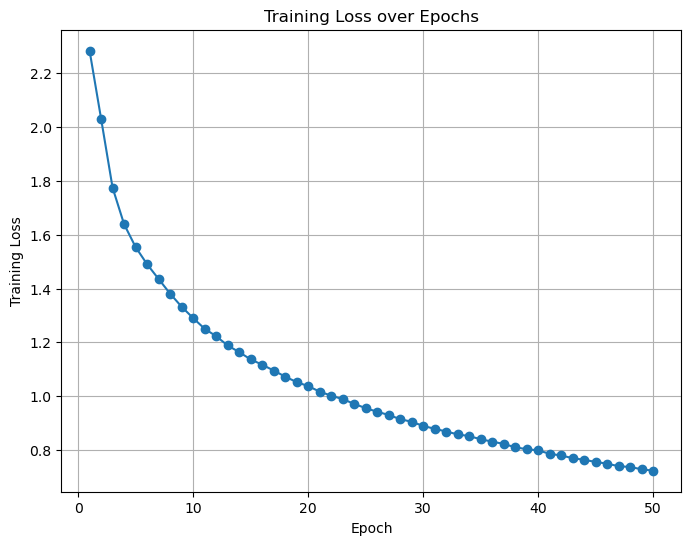

In [22]:
# ----------------------------
# Training & Evaluation
# ----------------------------
if __name__ == "__main__":
    # Reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Device selection
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Transforms
    transform = transforms.Compose([
        transforms.ToTensor(),  # HWC uint8 -> CHW float [0,1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # map to [-1,1]
    ])

    data_path = "data"  # folder containing CIFAR-10 batch files

    # Datasets
    train_dataset = CIFAR10Dataset(path=data_path, data_type='train', transform=transform)
    test_dataset = CIFAR10Dataset(path=data_path, data_type='test', transform=transform)

    # DataLoader settings:
    # --- CHANGED ---
    # Use num_workers = 0 when running on environments where spawn is the default
    # or when you hit "Can't get attribute 'CIFAR10Dataset' on <module '__main__'>"
    # that comes from multiprocessing pickling. Increase num_workers only if you
    # run this as a standalone script (python train_cifar_fixed.py) and classes are importable.
    num_workers = 0

    # pin_memory is only useful with CUDA. Avoid MPS warning by setting it conditionally.
    pin_memory = True if device.type == 'cuda' else False
    # ----------------

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory)

    # Model
    model = GeneralCNN()  # default architecture per assignment
    model.to(device)

    # Loss and optimizer (optimizer created after model param creation) --- no longer a bug because FCs built in __init__
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Debug: verify optimizer sees all parameters
    total_params = sum(p.numel() for p in model.parameters())
    opt_params = sum(p.numel() for g in optimizer.param_groups for p in g['params'])
    print(f"Total model params: {total_params}, Optimizer params: {opt_params}")
    assert total_params == opt_params, "Parameter count mismatch: optimizer may not include all model parameters"

    # Training loop
    num_epochs = 50
    train_losses = []
    from tqdm.notebook import tqdm

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        running_loss = 0.0
        batch_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Batches", leave=False)
        for i, (images, labels) in enumerate(batch_loop):
            images, labels = images.to(device, non_blocking=(num_workers>0)), labels.to(device, non_blocking=(num_workers>0))
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_loop.set_postfix({"loss": running_loss / (i + 1)})

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {epoch_loss:.4f}")

    print("Training finished!")

    # Plot training loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.show()


Overall Test Accuracy: 0.6772
              precision    recall  f1-score   support

           0     0.6710    0.7220    0.6956      1000
           1     0.7902    0.7760    0.7830      1000
           2     0.5612    0.5730    0.5670      1000
           3     0.4824    0.5220    0.5014      1000
           4     0.6605    0.6090    0.6337      1000
           5     0.5920    0.5470    0.5686      1000
           6     0.7419    0.8050    0.7722      1000
           7     0.8022    0.6450    0.7151      1000
           8     0.7129    0.8220    0.7636      1000
           9     0.7897    0.7510    0.7699      1000

    accuracy                         0.6772     10000
   macro avg     0.6804    0.6772    0.6770     10000
weighted avg     0.6804    0.6772    0.6770     10000

Mean ROC AUC: 0.9473


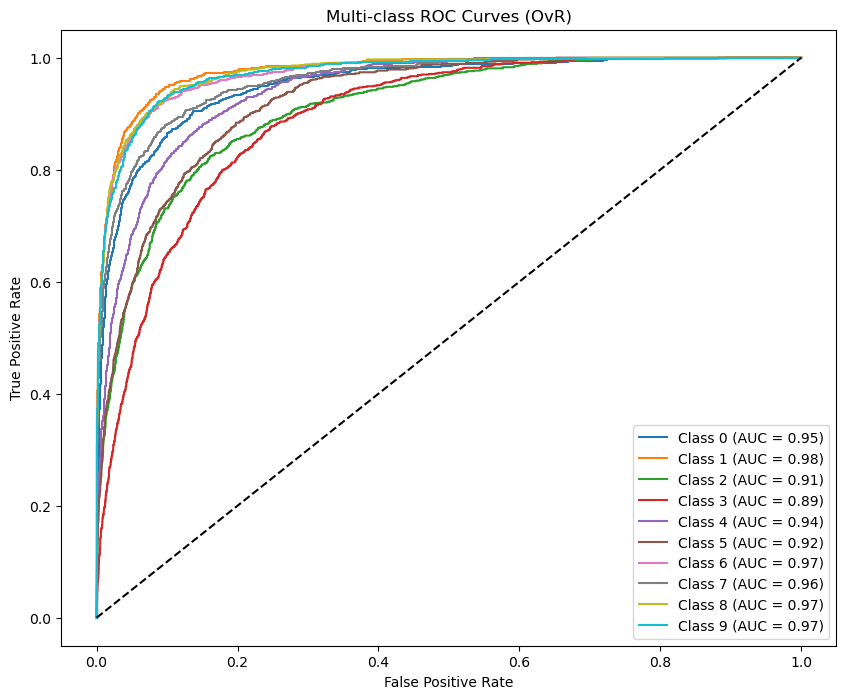

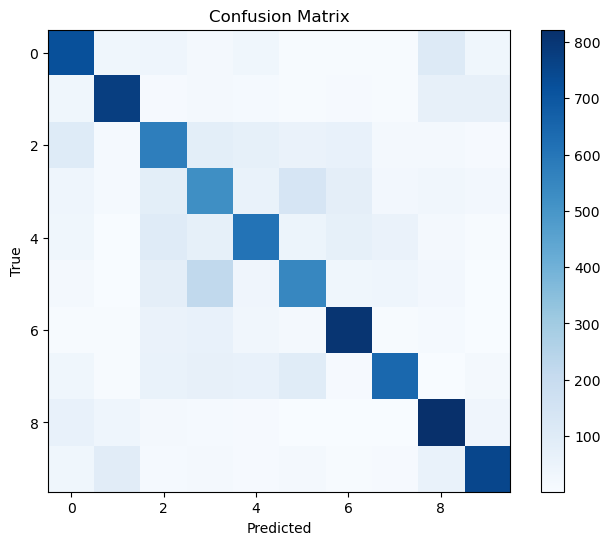

In [23]:
# -----------------------------
# Evaluation
# -----------------------------
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu())
        all_labels.append(labels)

all_probs = torch.cat(all_probs, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

pred_classes = all_probs.argmax(axis=1)
accuracy = accuracy_score(all_labels, pred_classes)
print(f"Overall Test Accuracy: {accuracy:.4f}")

print(classification_report(all_labels, pred_classes, digits=4))

n_classes = 10
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))
roc_auc = roc_auc_score(all_labels_bin, all_probs, multi_class='ovr')
print(f"Mean ROC AUC: {roc_auc:.4f}")

# ROC curves (optional)
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr,tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves (OvR)')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix (optional)
cm = confusion_matrix(all_labels, pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Sencond Full Version - 13/11/2025 --------------------------------------------------------**
**All requested changes made: accuracy corrected, confusion matrixes ploted, running time, comparizon nrom vs non-norm results**

All of the plots are saved in folders inside our workspace :)

In [1]:
"""
CIFAR-10 training script extended with confusion-matrix-derived metrics.

This file is an updated version of your training script. New additions that
implement the confusion-matrix -> per-class metrics (following the
Towards Data Science article) are explicitly marked with:
    # --- ADDED METRICS ---

What changed / added:
 - A helper function `metrics_from_confusion_matrix(cm, class_names=None)` that
   computes TP, FP, FN, TN and derived metrics (precision, recall/sensitivity,
   specificity, F1, support) per class and macro averages.
   (Marked "# --- ADDED METRICS ---" where defined and where used.)
 - The run_experiment() routine now calls this helper for both train and test
   confusion matrices, prints the per-class metrics and saves them as CSV.
   (Marked "# --- ADDED METRICS ---" where results are printed/saved.)
 - The script preserves previous behavior: timing, plotting and saving confusions,
   train-vs-test confusion difference, and two experiments (normalized vs plain).

Run: python train_cifar_confusion_metrics.py
"""
import os
import pickle
import time
import json
import csv
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn.metrics import (roc_auc_score, roc_curve, auc,
                             confusion_matrix, classification_report, accuracy_score)
from sklearn.preprocessing import label_binarize

# ----------------------------
# CIFAR class names (for nicer outputs)
# ----------------------------
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat',
                   'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# ----------------------------
# Dataset
# ----------------------------
class CIFAR10Dataset(Dataset):
    def __init__(self, path, data_type='train', transform=None):
        self.path = path
        self.transform = transform

        if data_type == 'train':
            data_list = []
            labels_list = []
            for i in range(1, 6):
                file = os.path.join(path, f"data_batch_{i}")
                with open(file, 'rb') as fo:
                    batch = pickle.load(fo, encoding='bytes')
                    imgs = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                    data_list.append(imgs)
                    labels_list.extend(batch[b'labels'])
            self.data = np.vstack(data_list)  # shape (50000,3,32,32)
            self.labels = np.array(labels_list, dtype=np.int64)
        elif data_type == 'test':
            file = os.path.join(path, "test_batch")
            with open(file, 'rb') as fo:
                batch = pickle.load(fo, encoding='bytes')
                self.data = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                self.labels = np.array(batch[b'labels'], dtype=np.int64)
        else:
            raise ValueError("data_type must be 'train' or 'test'")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  # CHW (3,32,32)
        label = int(self.labels[idx])  # ensure int
        img = np.transpose(img, (1, 2, 0)).astype(np.uint8)  # HWC
        if self.transform:
            img = self.transform(img)
        return img, label

    def visualize(self, img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
        """Visualize a single image (tensor or NumPy array)."""
        if isinstance(img, torch.Tensor):
            t = img.clone().cpu()
            mean_t = torch.tensor(mean).view(3,1,1)
            std_t  = torch.tensor(std).view(3,1,1)
            t = t * std_t + mean_t
            npimg = t.numpy()
            npimg = np.transpose(npimg, (1, 2, 0))
            plt.imshow(npimg)
        else:
            plt.imshow(img)
        plt.axis('off')
        plt.show()

In [2]:
# ----------------------------
# Model
# ----------------------------
class GeneralCNN(nn.Module):
    def __init__(self,
                 in_channels=3,
                 num_classes=10,
                 conv_layers=[(6, 5), (16, 5)],
                 pool_type='max',
                 pool_kernel=3,
                 pool_stride=2,
                 fc_layers=[120, 84],
                 activation='relu',
                 input_size=(32, 32)):
        super(GeneralCNN, self).__init__()

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        else:
            raise ValueError("Unsupported activation")

        self.layers = nn.ModuleList()
        current_channels = in_channels

        for out_channels, kernel_size in conv_layers:
            conv = nn.Conv2d(current_channels, out_channels, kernel_size=kernel_size)
            self.layers.append(conv)
            current_channels = out_channels

        if pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)
        else:
            raise ValueError("pool_type must be 'max' or 'avg'")

        self.fc_config = fc_layers
        self.num_classes = num_classes

        # Compute flattened size using dummy tensor
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, input_size[0], input_size[1])
            x = dummy
            for conv in self.layers:
                x = conv(x)
                x = self.activation(x)
                if self.pool is not None:
                    x = self.pool(x)
            flattened_size = x.view(1, -1).shape[1]

        self.fc_layers = nn.ModuleList()
        input_size_fc = flattened_size
        for units in self.fc_config:
            self.fc_layers.append(nn.Linear(input_size_fc, units))
            input_size_fc = units
        self.fc_layers.append(nn.Linear(input_size_fc, self.num_classes))

    def forward(self, x):
        for conv in self.layers:
            x = conv(x)
            x = self.activation(x)
            if self.pool is not None:
                x = self.pool(x)
        x = torch.flatten(x, 1)
        for i, fc in enumerate(self.fc_layers):
            if i < len(self.fc_layers) - 1:
                x = self.activation(fc(x))
            else:
                x = fc(x)
        return x

In [3]:
# --- METRICS -----------------------------
# Helper: compute per-class metrics from confusion matrix (one-vs-all)
# This follows the approach this requested article:
# https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872/
# ----------------------------

def metrics_from_confusion_matrix(cm, class_names=None):
    """
    Given a square confusion matrix cm (actual rows, predicted cols),
    compute per-class TP, FP, FN, TN and derived metrics:
      precision, recall (sensitivity), specificity, f1, support

    Returns:
      metrics_per_class: dict[class_name or index] -> dict of metrics
      summary: dict with macro-averages and overall accuracy
    """
    cm = np.array(cm, dtype=np.int64)
    n_classes = cm.shape[0]
    total = cm.sum()
    diag = np.diag(cm)
    metrics_per_class = {}
    eps = 1e-12

    for i in range(n_classes):
        TP = int(cm[i, i])
        FP = int(cm[:, i].sum() - TP)
        FN = int(cm[i, :].sum() - TP)
        TN = int(total - TP - FP - FN)

        precision = TP / (TP + FP + eps)
        recall = TP / (TP + FN + eps)  # sensitivity
        specificity = TN / (TN + FP + eps)
        f1 = 2 * precision * recall / (precision + recall + eps)
        support = int(cm[i, :].sum())

        name = class_names[i] if class_names is not None else str(i)
        metrics_per_class[name] = {
            'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
            'precision': precision, 'recall': recall,
            'specificity': specificity, 'f1': f1, 'support': support
        }

    # Overall metrics
    accuracy = diag.sum() / (total + eps)
    # macro averages
    macro_precision = np.mean([m['precision'] for m in metrics_per_class.values()])
    macro_recall = np.mean([m['recall'] for m in metrics_per_class.values()])
    macro_f1 = np.mean([m['f1'] for m in metrics_per_class.values()])

    summary = {
        'accuracy': accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'total': int(total)
    }

    return metrics_per_class, summary

In [ ]:
# ----------------------------
# Training & Evaluation helper
# ----------------------------
def run_experiment(exp_name,
                   transform,
                   data_path='data',
                   batch_size=128,
                   num_epochs=50,
                   device=None,
                   num_workers=0,
                   pin_memory=False,
                   class_names=None):
    """
    Train and evaluate one experiment (one transform).
    Returns a dict with metrics and timings.
    """
    print(f"\n=== Running experiment: {exp_name} ===")
    plots_dir = os.path.join("plots", exp_name)
    os.makedirs(plots_dir, exist_ok=True)

    # Datasets + loaders
    train_dataset = CIFAR10Dataset(path=data_path, data_type='train', transform=transform)
    test_dataset  = CIFAR10Dataset(path=data_path, data_type='test',  transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)
    eval_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,
                                   num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory)

    # Visualize first image (keeps previous behavior)
    try:
        img0, label0 = train_dataset[0]
        print(f"Sample visualization (exp={exp_name}) - Label: {label0}")
        # If the transform includes Normalize((0.5,...),(0.5,...)) this will unnormalize inside visualize
        # We cannot automatically detect the Normalize params reliably here, so we assume the common .5/.5 default.
        train_dataset.visualize(img0, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    except Exception as e:
        print("Could not visualize sample image:", e)

    # Model, loss, optimizer
    model = GeneralCNN()
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    total_params = sum(p.numel() for p in model.parameters())
    opt_params = sum(p.numel() for g in optimizer.param_groups for p in g['params'])
    print(f"Total model params: {total_params}, Optimizer params: {opt_params}")
    assert total_params == opt_params, "Parameter count mismatch: optimizer may not include all model parameters"

    # Training loop with timing
    train_losses = []
    epoch_times = []
    total_start = time.perf_counter()

    for epoch in range(num_epochs):
        epoch_start = time.perf_counter()
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device, non_blocking=(num_workers>0))
            labels = labels.to(device, non_blocking=(num_workers>0))
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        epoch_end = time.perf_counter()
        epoch_duration = epoch_end - epoch_start
        epoch_times.append(epoch_duration)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {epoch_loss:.4f} - Time: {epoch_duration:.2f}s")

    total_end = time.perf_counter()
    total_training_time = total_end - total_start
    print(f"Total training time for {exp_name}: {total_training_time:.2f}s")

    # Save training loss plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title(f'Training Loss over Epochs ({exp_name})')
    plt.grid(True)
    plt.tight_layout()
    loss_path = os.path.join(plots_dir, "loss.png")
    plt.savefig(loss_path)
    plt.close()
    print(f"Saved loss plot to {loss_path}")

    # Evaluation: compute preds on train and test
    model.eval()
    all_probs_test = []
    all_labels_test = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs_test.append(probs.cpu())
            all_labels_test.append(labels)
    all_probs_test = torch.cat(all_probs_test, dim=0).numpy()
    all_labels_test = torch.cat(all_labels_test, dim=0).numpy()

    all_probs_train = []
    all_labels_train = []
    with torch.no_grad():
        for images, labels in eval_train_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs_train.append(probs.cpu())
            all_labels_train.append(labels)
    all_probs_train = torch.cat(all_probs_train, dim=0).numpy()
    all_labels_train = torch.cat(all_labels_train, dim=0).numpy()

    # Compute basic metrics
    pred_test = all_probs_test.argmax(axis=1)
    accuracy_test = accuracy_score(all_labels_test, pred_test)
    # Use target_names=class_names so labels are printed as class names
    report_test = classification_report(all_labels_test, pred_test, target_names=class_names, digits=4)
    print("\n--- Classification Report (TEST) ---")
    print(report_test)
    # save classification report to file
    with open(os.path.join(plots_dir, "classification_report_test.txt"), "w") as f:
        f.write(report_test)


    pred_train = all_probs_train.argmax(axis=1)
    accuracy_train = accuracy_score(all_labels_train, pred_train)
    report_train = classification_report(all_labels_train, pred_train, target_names=class_names, digits=4)
    print("\n--- Classification Report (TRAIN) ---")
    print(report_train)
    # save classification report to file
    with open(os.path.join(plots_dir, "classification_report_train.txt"), "w") as f:
        f.write(report_train)

    # ROC AUC (test)
    n_classes = len(class_names) if class_names is not None else 10
    all_labels_test_bin = label_binarize(all_labels_test, classes=np.arange(n_classes))
    try:
        roc_auc_test = roc_auc_score(all_labels_test_bin, all_probs_test, multi_class='ovr')
    except Exception:
        roc_auc_test = float('nan')

    # Confusion matrices (train and test)
    cm_test = confusion_matrix(all_labels_test, pred_test)
    cm_train = confusion_matrix(all_labels_train, pred_train)

    # Save confusion matrices with counts and annotation (unchanged)
    def plot_and_save_cm(cm, title, path, class_names=None):
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        plt.colorbar()
        plt.xlabel('Predicted')
        plt.ylabel('True')
        # annotate counts
        thresh = cm.max() / 2. if cm.max() > 0 else 0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(int(cm[i, j]), 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        if class_names is not None:
            plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')
            plt.yticks(np.arange(len(class_names)), class_names)
        plt.tight_layout()
        plt.savefig(path)
        plt.close()
        print(f"Saved confusion matrix to {path}")

    plot_and_save_cm(cm_test, f'Confusion Matrix (Test) - {exp_name}', os.path.join(plots_dir, "confusion_test.png"), class_names=class_names)
    plot_and_save_cm(cm_train, f'Confusion Matrix (Train) - {exp_name}', os.path.join(plots_dir, "confusion_train.png"), class_names=class_names)

    # Difference matrix (train - test)
    cm_diff = cm_train.astype(int) - cm_test.astype(int)
    plot_and_save_cm(cm_diff, f'Confusion Matrix (Train - Test) - {exp_name}', os.path.join(plots_dir, "confusion_diff.png"), class_names=class_names)

    # --- ADDED METRICS ---
    # Compute per-class metrics from confusion matrices using our helper
    metrics_test_per_class, metrics_test_summary = metrics_from_confusion_matrix(cm_test, class_names)
    metrics_train_per_class, metrics_train_summary = metrics_from_confusion_matrix(cm_train, class_names)

    # Save per-class metrics as CSVs for easy inspection
    def save_metrics_csv(metrics_per_class, summary, csv_path):
        # metrics_per_class is dict[class] -> dict(metrics)
        with open(csv_path, 'w', newline='') as csvfile:
            fieldnames = ['class', 'TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'specificity', 'f1', 'support']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for cls, metrics in metrics_per_class.items():
                row = {'class': cls}
                row.update({k: metrics[k] for k in ['TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'specificity', 'f1', 'support']})
                writer.writerow(row)
            # write summary as final rows
            writer.writerow({})
            writer.writerow({'class': 'SUMMARY', 'TP': '', 'FP': '', 'FN': '', 'TN': '', 'precision': summary['macro_precision'],
                             'recall': summary['macro_recall'], 'specificity': '', 'f1': summary['macro_f1'], 'support': summary['total']})
    save_metrics_csv(metrics_test_per_class, metrics_test_summary, os.path.join(plots_dir, "metrics_test_per_class.csv"))
    save_metrics_csv(metrics_train_per_class, metrics_train_summary, os.path.join(plots_dir, "metrics_train_per_class.csv"))

    # Print the per-class metrics summary to console
    print("\n--- Per-class metrics (TEST) ---")
    for cls, m in metrics_test_per_class.items():
        print(f"{cls}: precision={m['precision']:.4f}, recall={m['recall']:.4f}, specificity={m['specificity']:.4f}, f1={m['f1']:.4f}, support={m['support']}")
    print("TEST summary:", metrics_test_summary)

    print("\n--- Per-class metrics (TRAIN) ---")
    for cls, m in metrics_train_per_class.items():
        print(f"{cls}: precision={m['precision']:.4f}, recall={m['recall']:.4f}, specificity={m['specificity']:.4f}, f1={m['f1']:.4f}, support={m['support']}")
    print("TRAIN summary:", metrics_train_summary)
    # --- END ADDED METRICS ---

    # ROC curves (test) - save
    try:
        plt.figure(figsize=(10, 8))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(all_labels_test_bin[:, i], all_probs_test[:, i])
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr,tpr):.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multi-class ROC Curves (Test) ({exp_name})')
        plt.legend(loc='lower right')
        plt.tight_layout()
        roc_path = os.path.join(plots_dir, "roc_curves_test.png")
        plt.savefig(roc_path)
        plt.close()
        print(f"Saved ROC curves to {roc_path}")
    except Exception as e:
        print("Could not create ROC curves:", e)

    # Print summary
    print(f"\nSummary for {exp_name}:")
    print(f"  Train accuracy: {accuracy_train:.4f}")
    print(f"  Test  accuracy: {accuracy_test:.4f}")
    print(f"  Test  ROC AUC  : {roc_auc_test:.4f}")
    print(f"  Total training time: {total_training_time:.2f}s")
    print(f"  Epoch times (s): {[round(t,2) for t in epoch_times]}")

    return {
        'exp_name': exp_name,
        'train_losses': train_losses,
        'epoch_times': epoch_times,
        'total_time': total_training_time,
        'accuracy_train': accuracy_train,
        'accuracy_test': accuracy_test,
        'report_train': report_train,   
        'report_test': report_test,   
        'roc_auc_test': roc_auc_test,
        'confusion_train': cm_train,
        'confusion_test': cm_test,
        'confusion_diff': cm_diff,
        'metrics_test_per_class': metrics_test_per_class,
        'metrics_train_per_class': metrics_train_per_class,
        'plots_dir': plots_dir
    }


Device: cpu

=== Running experiment: normalized ===
Sample visualization (exp=normalized) - Label: 6


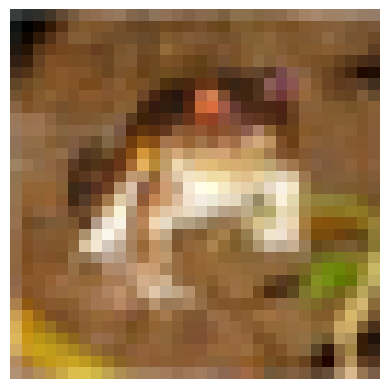

Total model params: 44726, Optimizer params: 44726
Epoch [1/50] - Avg Loss: 2.2985 - Time: 14.94s
Epoch [2/50] - Avg Loss: 2.2688 - Time: 10.19s
Epoch [3/50] - Avg Loss: 2.1255 - Time: 12.20s
Epoch [4/50] - Avg Loss: 1.9238 - Time: 13.10s
Epoch [5/50] - Avg Loss: 1.8040 - Time: 16.10s
Epoch [6/50] - Avg Loss: 1.7180 - Time: 13.35s
Epoch [7/50] - Avg Loss: 1.6451 - Time: 11.54s
Epoch [8/50] - Avg Loss: 1.5926 - Time: 10.64s
Epoch [9/50] - Avg Loss: 1.5494 - Time: 10.45s
Epoch [10/50] - Avg Loss: 1.5144 - Time: 10.80s
Epoch [11/50] - Avg Loss: 1.4823 - Time: 10.47s
Epoch [12/50] - Avg Loss: 1.4469 - Time: 10.31s
Epoch [13/50] - Avg Loss: 1.4179 - Time: 10.44s
Epoch [14/50] - Avg Loss: 1.3947 - Time: 10.27s
Epoch [15/50] - Avg Loss: 1.3651 - Time: 10.26s
Epoch [16/50] - Avg Loss: 1.3394 - Time: 10.78s
Epoch [17/50] - Avg Loss: 1.3096 - Time: 13.06s
Epoch [18/50] - Avg Loss: 1.2878 - Time: 10.81s
Epoch [19/50] - Avg Loss: 1.2635 - Time: 14.30s
Epoch [20/50] - Avg Loss: 1.2476 - Time: 13.44

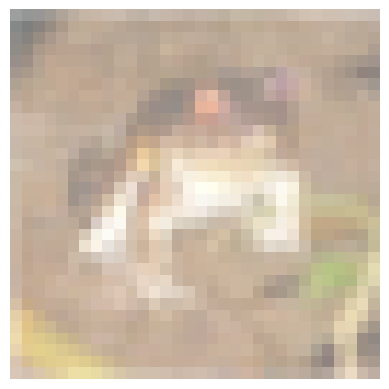

Total model params: 44726, Optimizer params: 44726
Epoch [1/50] - Avg Loss: 2.3024 - Time: 6.66s
Epoch [2/50] - Avg Loss: 2.2977 - Time: 6.96s
Epoch [3/50] - Avg Loss: 2.2893 - Time: 6.92s
Epoch [4/50] - Avg Loss: 2.2692 - Time: 7.11s
Epoch [5/50] - Avg Loss: 2.2217 - Time: 8.17s
Epoch [6/50] - Avg Loss: 2.1720 - Time: 6.63s
Epoch [7/50] - Avg Loss: 2.0659 - Time: 6.61s
Epoch [8/50] - Avg Loss: 2.0028 - Time: 6.42s
Epoch [9/50] - Avg Loss: 1.9546 - Time: 6.44s
Epoch [10/50] - Avg Loss: 1.8921 - Time: 6.40s
Epoch [11/50] - Avg Loss: 1.8267 - Time: 6.62s
Epoch [12/50] - Avg Loss: 1.7611 - Time: 6.33s
Epoch [13/50] - Avg Loss: 1.7048 - Time: 6.56s
Epoch [14/50] - Avg Loss: 1.6541 - Time: 6.94s
Epoch [15/50] - Avg Loss: 1.6202 - Time: 6.34s
Epoch [16/50] - Avg Loss: 1.5823 - Time: 6.27s
Epoch [17/50] - Avg Loss: 1.5589 - Time: 10.25s
Epoch [18/50] - Avg Loss: 1.5341 - Time: 7.49s
Epoch [19/50] - Avg Loss: 1.5164 - Time: 9.62s
Epoch [20/50] - Avg Loss: 1.4965 - Time: 9.28s
Epoch [21/50] - A

In [5]:
# ----------------------------
# Main: run normalized and not-normalized experiments
# ----------------------------
if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    data_path = "data"
    num_workers = 0
    pin_memory = True if device.type == 'cuda' else False

    batch_size = 64
    num_epochs = 50  # reduce for quick testing if desired

    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    transform_plain = transforms.Compose([transforms.ToTensor()])

    res_norm = run_experiment("normalized", transform_norm,
                              data_path=data_path,
                              batch_size=batch_size,
                              num_epochs=num_epochs,
                              device=device,
                              num_workers=num_workers,
                              pin_memory=pin_memory,
                              class_names=CIFAR10_CLASSES)

    res_plain = run_experiment("not_normalized", transform_plain,
                               data_path=data_path,
                               batch_size=batch_size,
                               num_epochs=num_epochs,
                               device=device,
                               num_workers=num_workers,
                               pin_memory=pin_memory,
                               class_names=CIFAR10_CLASSES)

    # Save a high-level comparison summary
    summary_path = os.path.join("plots", "comparison_summary.txt")
    os.makedirs("plots", exist_ok=True)
    with open(summary_path, 'w') as f:
        f.write("Comparison: normalized vs not_normalized\n\n")
        f.write("Normalized results:\n")
        f.write(f"  Train acc: {res_norm['accuracy_train']:.4f}\n")
        f.write(f"  Test  acc: {res_norm['accuracy_test']:.4f}\n")
        f.write(f"  Total training time: {res_norm['total_time']:.2f}s\n\n")
        f.write("Not-normalized results:\n")
        f.write(f"  Train acc: {res_plain['accuracy_train']:.4f}\n")
        f.write(f"  Test  acc: {res_plain['accuracy_test']:.4f}\n")
        f.write(f"  Total training time: {res_plain['total_time']:.2f}s\n\n")

    print(f"\nSaved comparison summary to {summary_path}")
    print("Done.")